In [1]:
from fastai2.torch_basics import *
from fastai2.test import *
from fastai2.layers import *
from fastai2.data.all import *
from fastai2.data.block import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [2]:
labeller = RegexLabeller(pat = r'([^_]+).jpg$')
rotatedImagesDaBl = DataBlock(ts=(PILImage, Category), 
                       get_items=get_image_files, 
                       splitter=RandomSplitter(),
                       get_y=labeller)

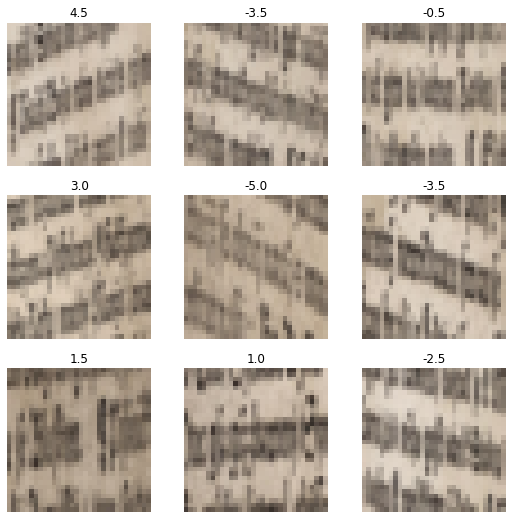

In [3]:
source = "../DATA/rotated_images/cropped/"
ds_img_tfms = [ToTensor(), Resize([32,32])]
dbch = rotatedImagesDaBl.databunch(source, bs=64, num_workers=8, ds_tfms=ds_img_tfms)
dbch.show_batch(max_n=9)

In [4]:
len(dbch.vocab)

21

In [5]:
def cnn_learner(arch, dbunch, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, progress=True, mixup=0, xtra_cb=None, **kwargs):
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(dbunch, arch(**arch_args), loss_func, opt_func=opt_func, lr=lr, **kwargs)

In [6]:
opt_func = partial(Adam, wd=0.01, eps=1e-3)

In [7]:
class LabelSmoothingCrossEntropy(Module):
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction  
    
    def forward(self, output, target):
        c = output.size()[-1]  
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)
    
    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

In [8]:
learn = cnn_learner(xresnet18, dbch, LabelSmoothingCrossEntropy(), opt_func=opt_func, c_in=3, c_out=21, lr=1e-2, metrics=accuracy)

In [9]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.453988,2.261236,0.261655,01:13
1,1.696570,1.940653,0.355313,00:12
2,1.451160,1.500704,0.532969,00:13
3,1.388156,1.243744,0.708946,00:13
4,1.291975,1.322692,0.641747,00:13
5,1.248836,1.634022,0.490550,00:13
6,1.176377,1.287080,0.683746,00:13
7,1.123214,1.248555,0.707266,00:13
8,1.062570,1.089813,0.774885,00:12
9,1.003701,1.307967,0.656027,00:12


In [29]:
import numpy as np
source = "../DATA/rotated_images/cropped_test_set_bw//"
items = get_image_files(source)
from collections import defaultdict
dd = defaultdict(list)
ix = 0
for i in items:
    dd[str(i).split("_")[-1]].append(float(learn.predict(i)[0]))
for k,v in dd.items():
    print(k,np.mean(v))

10v.jpg 1.1923076923076923
03v.jpg -1.5
16r.jpg -4.0


In [43]:
learn.save("resnet18trained.fai")

In [10]:
learn.load("resnet18trained.fai")

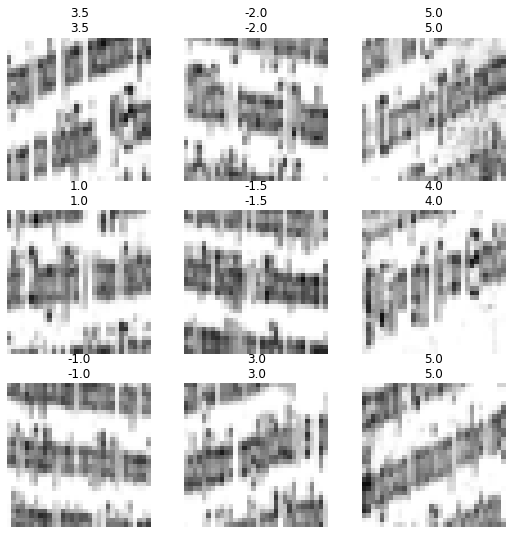

In [45]:
learn.show_results(max_n=9)